## Анализ и подготовка плана действий по удержанию клиентов в сети фитнес-центров

Настоящее исследование направлено на разработку стратегии по удержанию клиентов сети фитнес-центров на основе аналитических данных. Потребность в исследовании обусловлена проблемой связанной с оттоком клиентов.

Как правило, клиенты чаще перестают пользоваться сервисом тихо. Индикаторы оттока зависят от специфики отрасли. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Исследование построено на анкетах пользователей Сети фитнес-центров.

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Постановка задачи.](#step_1)
* [2. Загрузка данных и изучение общей информации.](#step_2)
* [3. EDA](#step_3)
* [4. Построение модели прогнозирования оттока клиентов](#step_4) 
* [5. Кластеризация клиентов](#step_5)
* [6. Выводы и рекомендации](#step_6)

In [1]:
# Библиотеки для обработки данных
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             roc_curve, auc, silhouette_score)

# Настройки отображения данных
pd.set_option('max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
gbs = '\033[32m' # переменная для цвета в коде начало
gbe = '\033[0m'  # переменная для цвета в коде конец

# Библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Отключим предупреждения анаконды
import warnings
warnings.filterwarnings('ignore')

## 1. Постановка задачи
[к оглавлению](#step_0)
<a class="anchor" id="step_1"></a>

__Формулирование бизнес-задачи__.   
__________
В рамках масштабной стратегии "Сети" по взаимодействию с клиентами необходимо составить модель, которая на основе аналитических данных будет предсказывать склонен ли клиент к прекращению взаимоотношений с "Сетью" или нет.  

Для этого дадим себе ответы на следующие вопросы:  


| ВОПРОС | ОТВЕТ |
|:----|:------:|
|Что мы прогнозируем и <br>какую бизнес-задачу этим решаем? | Останется ли клиент с "Сетью" <br>в следующем месяце или уйдет в отток|
| Какие данные для этого есть?| Сведения от заказчика в csv-файлах, <br>которые содержат данные на месяц до<br> оттока и факт оттока на определённый месяц|
| Кто и как будет использовать вашу модель <br>(как она встраивается в бизнес-процесс)?| Маркетологи и CRM |
| Как в компании до вас решали эту проблему<br> и насколько успешно?| Видимо никак|
| Какой бизнес-эффект<br> может дать ваша модель?| Планирование расходов на пополнение выбывших клиентов <br>Определение стратегии по работе с клиентами <br>согласно их типовых характеристик |
| Достаточно ли у вас ресурсов <br>(время, люди, финансы, вычислительные ресурсы)? | Да |
| По каким метрикам вы будете оценивать<br> качество работы вашей модели? | Cпустя мецяц ожидается что <br>Churn Rate будет соответствовать предсказанному  |
| Есть ли успешные бенчмарки <br>использования машинного обучения в подобных задачах? | Нет |


## 2. Загрузка данных и изучение общей информации.
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

Загрузим данные, отобразим первые 5 строк и базовую информацию.

In [2]:
try:
    df = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
display(df.head())
display(df.info())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.2275,5.0000,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12.0000,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1.0000,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12.0000,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1.0000,3,1.1139,1.1201,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Очевидно, пропусков в нашем наборе нет

Изучим содержимое столбцов и проверим соответствие типов данных:  

| Название | Тип | Значения | Содержание |
|:----|:------:|:------:|:------:|
|<!----> ___Данные клиента за предыдущий до проверки факта оттока месяц___|
|`Gender`|Категориальный|Один/Другой|Пол |
|`Near_Location`|Категориальный|Да/Нет|проживание или работа в районе, где находится фитнес-центр.|
|`Partner`|Категориальный|Да/Нет|сотрудник компании-партнёра клуба|
|`Promo_friends`|Категориальный|Да/Нет|факт первоначальной записи в рамках акции «приведи друга»|
|`Phone`|Категориальный|Да/Нет|наличие контактного телефона|
|`Age`|Числовой|Годы|возраст|
|`Lifetime`|Числовой|Месяцы|время с момента первого обращения в фитнес-центр
|<!----> ___Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента___|
|`Contract_period`|Категориальный|Месяц, 6 месяцев, год|длительность текущего действующего абонемента|
|`Month_to_end_contract`|Числовой|Месяцы|срок до окончания текущего действующего абонемента|
|`Group_visits`|Категориальный|Да/Нет|факт посещения групповых занятий|
|`Avg_class_frequency_total`|Числовой|Разы|средняя частота посещений в неделю за все время с начала действия абонемента|
|`Avg_class_frequency_current_month`|Числовой|Разы|средняя частота посещений в неделю за предыдущий месяц|
|`Avg_additional_charges_total`|Числовой|Деньги|суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон|
|<!----> ___Целевая переменная___|
|`Churn`|Категориальный|Да/Нет|факт оттока в текущем месяце|

In [4]:
print(f'В датафрейме выявлено {gbs}{df.duplicated().sum()}{gbe} дубликатов')

В датафрейме выявлено 0 дубликатов


Проверка на дубликаты отклонений не выявила.  
Для порядка приведем названия столбцов к змеиному стилю.

In [5]:
df.columns = [column.lower() for column in df.columns]
print(*df.columns, sep=' * ')

gender * near_location * partner * promo_friends * phone * contract_period * group_visits * age * avg_additional_charges_total * month_to_end_contract * lifetime * avg_class_frequency_total * avg_class_frequency_current_month * churn


Наш набор содержит числовые и категориальные признаки. Категориальные представлены бинарно. Если __"да"__ то __1__, если __"нет"__ - __0__. Срок заключения контракта представлен числами __1, 6, 12__. Эти значения можно рассматривать как тип договора и перевести в бинарную категорию.

In [6]:
df = pd.get_dummies(data=df, columns=['contract_period']).copy()

## 2. EDA.
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>

Оценим размеры датафрейма и выведем среднее по каждому признаку в двух группах - ушедших и оставшихся. В бинарных признаках, коэффициент будет говорить о доле признака в группе. Если 0.5 - значит признаков поровну, если ближе к __1__ - значит преобладает признак __"да"__. В числовых среднее это собственно среднее. 

In [7]:
print(f'Размер таблицы {df.shape[0]} строк {df.shape[1]} столбцов')
stat = df.groupby('churn').mean().T.reset_index()
stat.columns = ['feature', 'loyal', 'churn']
stat.style.set_caption('Средние значения признаков в группах\nоставшихся и попавших в отток клиентов').hide_index()

Размер таблицы 4000 строк 16 столбцов


feature,loyal,churn
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582
lifetime,4.711807,0.990575


Дополним полученную таблицу графиками и сделаем первые выводы.

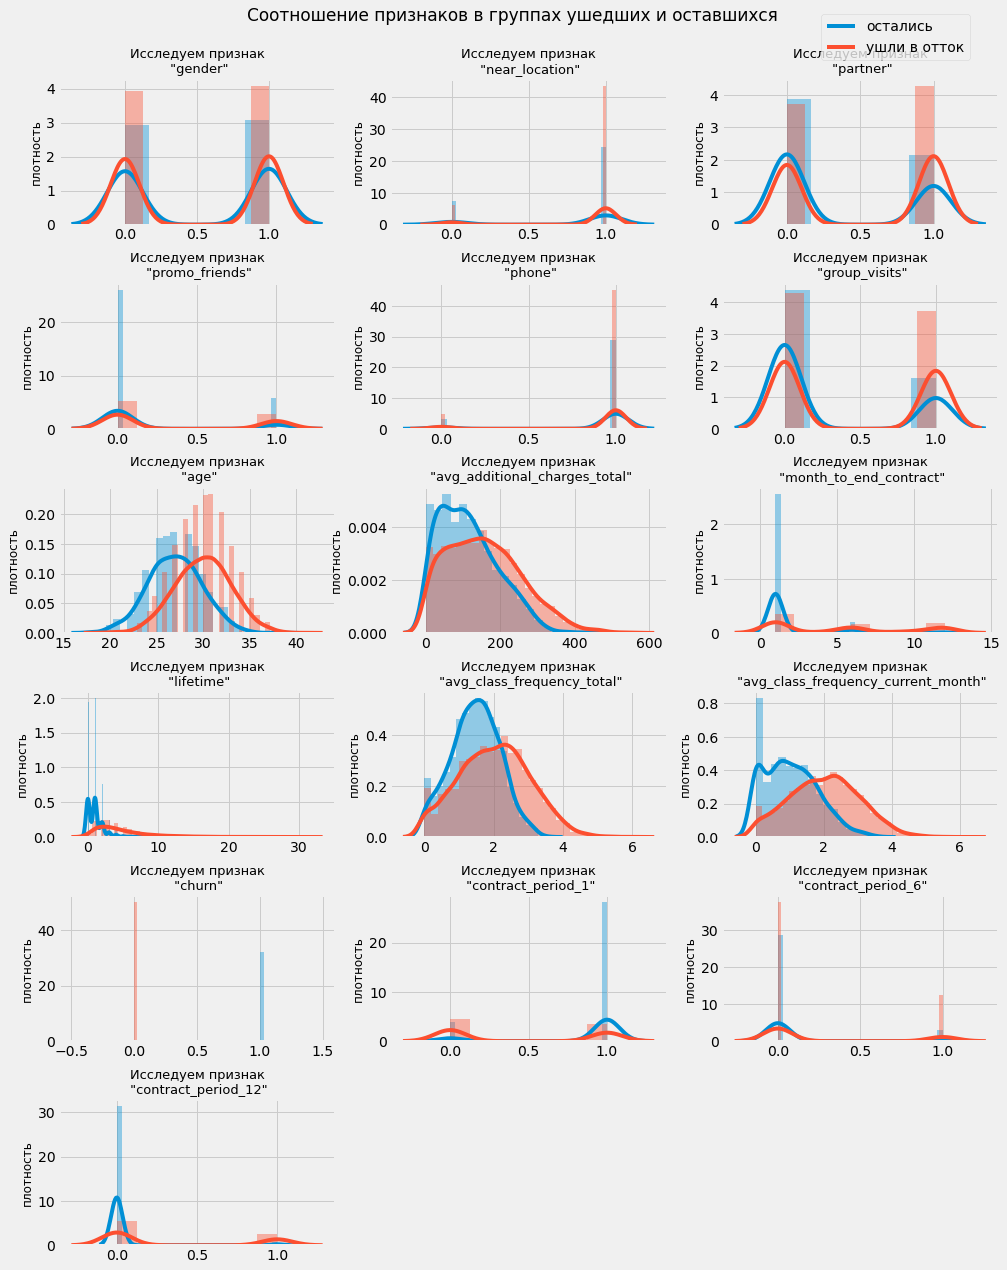

In [8]:
fig = plt.figure(figsize=(15,20))
for i,col in enumerate(df.columns):
    fig.add_subplot(6, 3, i+1)
    sns.distplot(df.query('churn == 1')[col])
    sns.distplot(df.query('churn != 1')[col])
    plt.title(f'Исследуем признак\n "{col}"', size=13)
    plt.xlabel('', size=12)
    plt.ylabel('плотность', size=12)
plt.suptitle('Соотношение признаков в группах ушедших и оставшихся', size=17, y=0.93)
fig.legend(labels=['остались','ушли в отток'], bbox_to_anchor=(0.93,0.93))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

1. В группах ушедших и оставшихся клиенты распределены по полам примерно 50/50.   
2. Живущие или работающие недалеко от спортклуба уходят в отток реже 87% в оставшихся и 76% в ушедших. Такой высокий процент в обеих группах говорит о том что клиенты преимущественно местные, но кто живет подальше все же уходят чаще.
3. Пришедшие по партнерской программе реже оказываются в оттоке 53% в оставшихся и 35% в ушедших.
4. Среди ушедших лишь 18% пришли по промо "Приведи друга", среди оставшихся 35%. Учитывая что далеко не все приходят в "Сеть" по этому каналу, он все таки способствует некоей лояльности.
5. По 90% клиентов в обеих группах оставили свои телефоны или персональные данные.
6. 74% ушедших не ходили на групповые занятия. Около 55% из оставшихся так же их не посещают.
7. Половина из оставшихся клиентов не моложе 30 лет и половины ушедших не моложе 27. В среднем в обеих группах возраст 29 лет.
8. Ушедшие потратили на дополнительные услуги примерно 115 денег, оставшиеся около 158. Согласно персентилям оставшиеся в принципе больше тратят денег.
9. У не менее 75% ушедших до конца контракта оставалось 1 и менее мес. У половины оставшихся до конца контракта не менее 6 мес.
10. Не менее 75% клиентов продержались месяц и меньше. Те кто остался - не менее 25% занимаются больше 2 мес.  
11. Попавшие в отток клиенты ходили в группы в среднем 1 раз в неделю, причем 25% не ходили вовсе. 50% Оставшихся посещают классы не менее 2 занятий в неделю.
12. Из тех кто взял 1-месячный контракт около 90% ушло в отток, кто взял 6-месячный или годовой контракт преимущественно задержались подольше.

Проверим как признаки коррелируют между собой

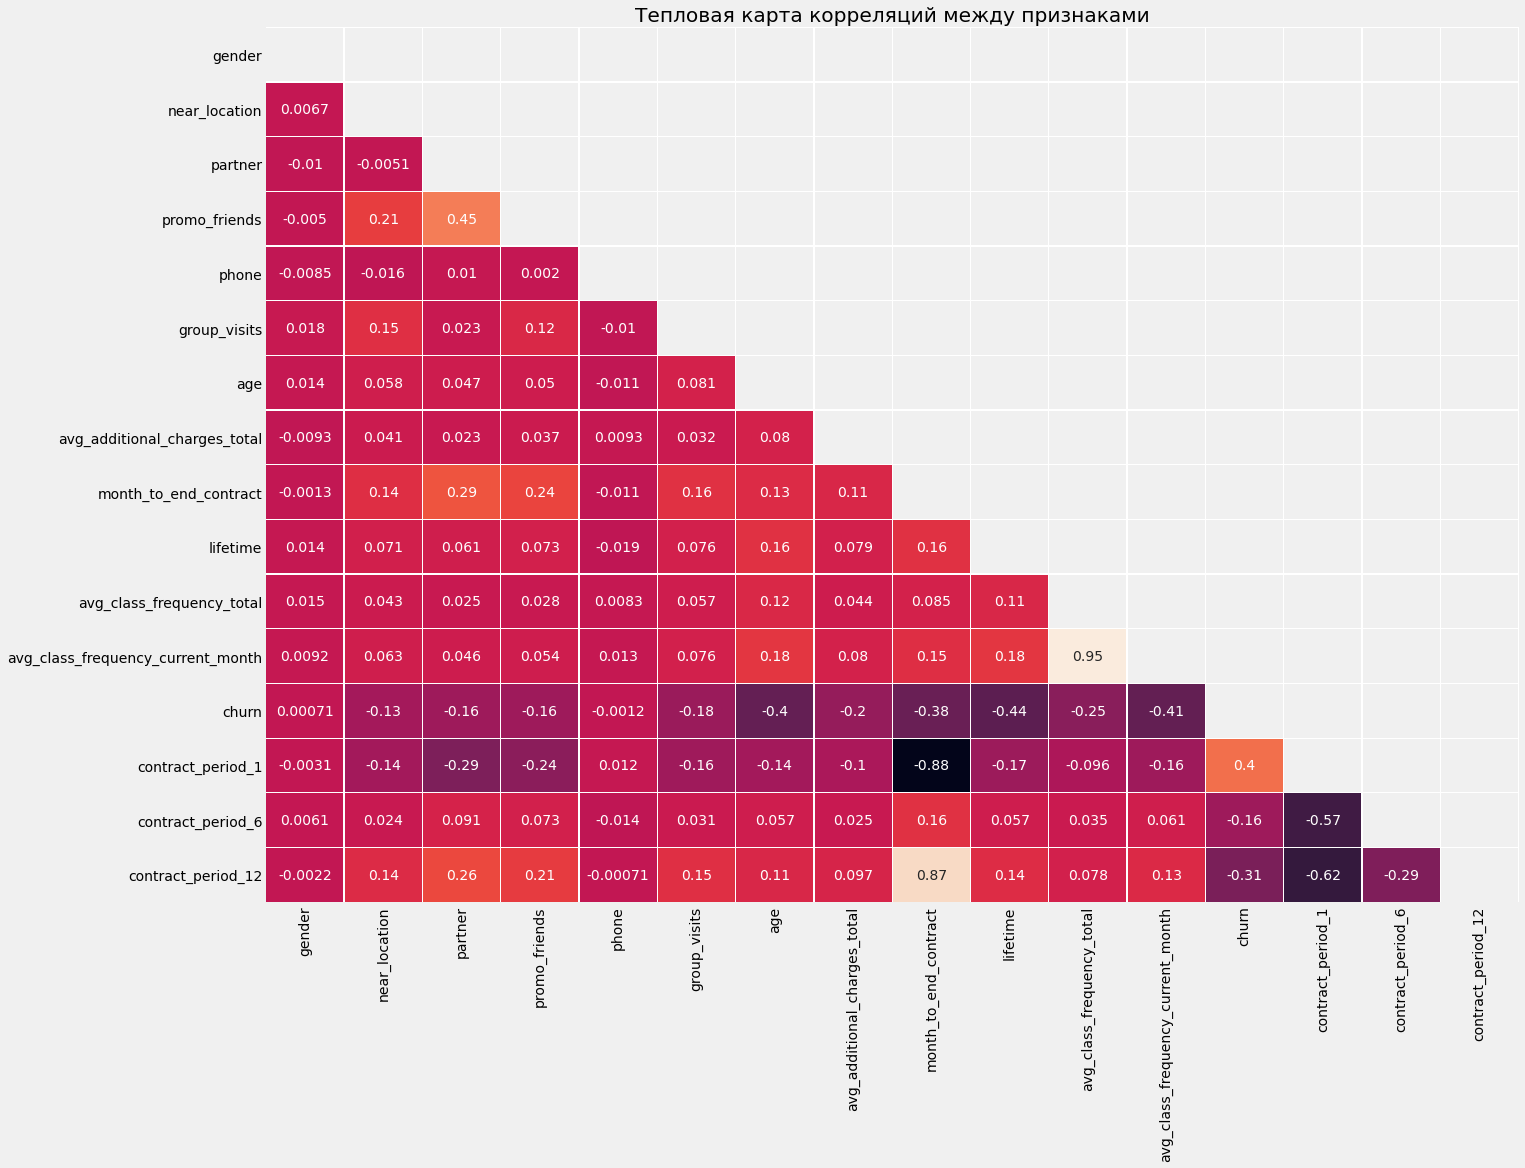

In [9]:
fig = plt.figure(figsize=(20,15))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

У практически всех признаков корреляция незначительная. Исключение составляют __month_to_end_contract__ & __contract period__ и __Avg_class_frequency_current_month__ & __Avg_class_frequency_current_total__. Один из пары признаков стоит удалить, т.к. сильно скоррелированные признаки будут переобучать модель.

In [10]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1).copy()

Исследовав признаки и избавившись от мультиколлинеарности приступим к формализации задачи.

__Формализация задачи__.   
__________
Проведя первичный осмотр данных и проанализировав требования заказчика принимаем решение двигаться в двух направлениях:
1) Прогнозирование бинарного класса   
2) Формирование типичных портретов клиентов: выделение несколько наиболее ярких групп и характеристика их свойств

| ВОПРОС | Задача №1 | Задача №2 |
|:----|:------:|:------:|
|Определение типа задачи| Обучение с учителем: <br>бинарная классификация| Обучение без учителя: <br>кластеризация |
|Какие алгоритмы планируем использовать? | Логистическая регрессия <br> Дерево принятия решений <br>Случайный лес <br>Градиентный бустинг |K-Means <br>Агломеративная иерархическая кластеризация|
|Какие данные выбрать в качестве признаков?| Все столбцы датасета кроме `churn`<br> и сильно коррелирующих <br>столбцов c остальными<br>`avg_class_frequency_current_month`<br> `month_to_end_contract`  |Все столбцы датасета кроме `churn`|
|Каков размер выборки?| 4000 строк | 4000 строк |
|За какой период данные?| Календарный месяц|Календарный месяц|
|Каково качество этих данных?| Пропусков нет <br> дублей нет <br> признаки преимущественно бинарные|Пропусков нет <br> дублей нет <br> признаки преимущественно бинарные|
|Есть ли в данных временная структура?| Нет | Нет |
|Какие метрики будем использовать <br>при оптимизации и оценке качества модели? | Accuracy<br>Precision<br>Recall<br>F1-score <br>ROC AUC |Silhouette|


## 4. Построение модели прогнозирования оттока клиентов
[к оглавлению](#step_0)
<a class="anchor" id="step_4"></a>

Для удобства соберем модели, с которыми будем работать в словарь. 

In [11]:
models = {LogisticRegression(random_state=0): 'Логистическая регрессия',
          DecisionTreeClassifier(random_state=0): 'Древо решений',
          RandomForestClassifier(random_state=0): 'Случайный лес',
          GradientBoostingClassifier(random_state=0): 'Градиентный бустинг'}          

Напишем необходимые функции

In [12]:
def make_prediction(m, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Датафрейм делится на признаки и Целевую переменную
    2) Выборка делится на обучающую и валидационную 80/20
    3) Обучающая выборка z преобразуется (средняя=0, std=1)
    4) Обучаем модель на преобразованной выборке
    5) Выдаем тестовый вектора целевой переменной, предсказаний целевой переменной и вероятности персказаний целевой переменной
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    return y_test, y_pred, y_proba

In [13]:
def metrics_dict(y_true, y_pred, y_proba, threshold = 0.5):
    '''
    ФУНКЦИЯ ДЛЯ РАСЧЕТА МЕТРИК
    ---------------------------
    На вход подаются вектора истиной целевой переменной, 
    предсказанной целевой переменной, 
    уверенности модели отнесения к классу и порог балансов классов.
    Внутри происходит следующее:
    1) Создаем пустой словаь - заготовоку
    2) Если веороятность отнесения к классу меньше порога значимости отнесем его к 0, инече к 1
    этот порог по умолчанию 50% но в случае несбалансированной выборки его можно поправить
    3) По мере расчета метрик, ключем назнасим название метрики, значением ее рассчет
    '''
    metrics = {}
    custom_predictions = [0 if i < threshold else 1 for i in y_pred]
    metrics['Accuracy'] = (accuracy_score(y_true, custom_predictions))
    metrics['Precision'] = (precision_score(y_true, custom_predictions))
    metrics['Recall'] = (recall_score(y_true, custom_predictions))
    metrics['F1'] = (f1_score(y_true, custom_predictions))
    metrics['ROC AUC'] = (roc_auc_score(y_true, y_proba))
    return metrics

In [14]:
def choose_model(models_dict, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ВЫБОРА МОДЕЛИ
    ---------------------------
    На вход подается словарь с моделями, датафрейм, название столбца с целевой переменной 
    Внутри происходит следующее:
    1) Создаем пустой словаь - заготовоку
    2) Циклом проходимся по словарю
    3) С помощью ключ словаря - модуля с моделью получаем необходимые вектора
    4) С помощью векторов заполняем словарь, где его ключи это понятные названия модели а значения рассчитанные метрики
    5) Из полученного словаря сформируем датафрейм
    '''
    matrix = {}
    for key in models_dict:
        y_test, y_pred, y_proba = make_prediction (key, df, target)
        matrix[models[key]] = metrics_dict(y_test, y_pred, y_proba)
    matrix = pd.DataFrame(matrix)
    matrix.loc['Total']= matrix.sum()
    return matrix

In [15]:
def make_roc(m, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ROC_AUC
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Создаем верктора предсказанных целевых переменных и их вероятностей
    2) Методом roc_cerve() рассчитаем FPR TPR и порог баланса классов
    3) На выходе ролучаем ошибки FPR TPR и значение AUC
    4) 
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

Отобразим графики площадь под кривой ошибок или ROC AUC. Чем ближе кривая ошибок выгибается к верхнему левому углу тем меньше доля ложно-положительных оценок и соответственно модель лучше.

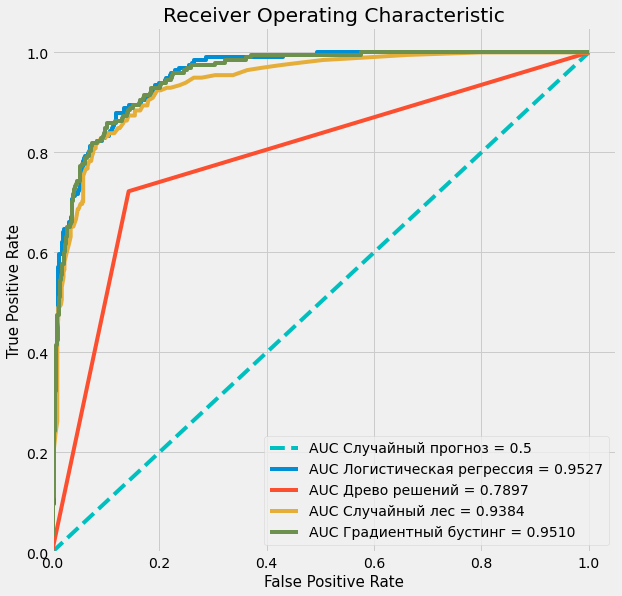

In [16]:
plt.figure(figsize = (9,9), linewidth= 1)
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'c--', label = 'AUC Случайный прогноз = 0.5') # Задаем лининию случайного AUC=0.5 как диагональ
for i in models:
    a, b, c = make_roc(i, df, 'churn')
    plt.plot(a, b, label = f'AUC {models[i]} = {c:.4f}')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1.05]) # Задаем полотно плота
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate', size=15)
    plt.xlabel('False Positive Rate', size=15)
plt.show()

Кроме __Древа решений__ все модели показывают отличный результат, но у __Логистической регрессии__ он все таки лучший.   

Дополним этот вывод матрицей метрик и выберем лучшую модель. Т.к. все метрики чем ближе к единице тем лучше характеризуют модель, их сумма будет неплохим критерием выбора.

In [17]:
choose_model(models, df, 'churn').style.highlight_max(axis='columns', color='#00FA9A')

,Логистическая регрессия,Древо решений,Случайный лес,Градиентный бустинг
Accuracy,0.898750,0.823750,0.893750,0.898750
Precision,0.788177,0.624454,0.792746,0.800000
Recall,0.808081,0.722222,0.772727,0.787879
F1,0.798005,0.669789,0.782609,0.793893
ROC AUC,0.952742,0.789683,0.938375,0.951030
Total,4.245755,3.629898,4.180207,4.231552


Остановим выбор на __Логистической регрессии__ с базовыми параметрами.

In [18]:
final_model = LogisticRegression(solver='liblinear', random_state=0)

Напишем функцию выводящую веса каждого признака в финальной модели. Это позволит "черный ящик" модели сделать более прозрачным и понимать изменение какого признака сильнее влияет на целевую переменную

In [19]:
def features(model, df, target):
    '''
    ФУНКЦИЯ ДЛЯ ОТРИСОВКИ ВАЖНОСТИ ПРИЗНАКОВ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Создаем верктора предсказанных целевых переменных и их вероятностей
    2) выводим коэффициенты весов атрибутами feature_importances_ или coef_
    3) Строим датафрейм с коэффииентами сос воим знаком и по модулю
    4) Рисуем из этотого датафрейма тепловую карту для красоты
    '''
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    try:
        coeff = model.feature_importances_
    except:
        coeff = model.coef_[0]
    features = pd.DataFrame({'feature': X.columns,'coeff': coeff})
    features['coeff_abs'] = features['coeff'].abs()
    features = features.sort_values(by='coeff_abs', ascending=False).set_index('feature')
    fig = plt.figure(figsize=(8,10))
    sns.heatmap(features,
                annot=True, 
                fmt='.3g', linecolor = 'white', linewidths=0.3, cbar=False)
    plt.title('Влияние признаков')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0, size=16)
    plt.yticks(rotation=0, size=12)
    plt.show()

Применяем функцию важности признаков и выводим таблицу

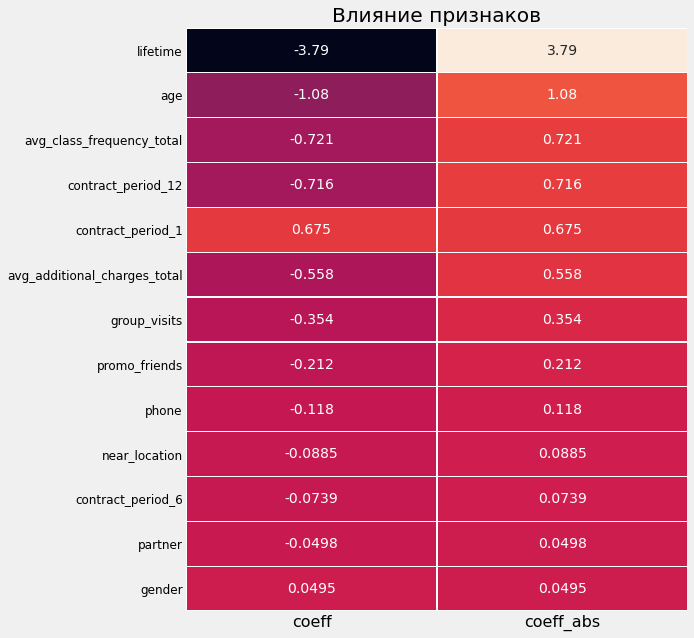

In [20]:
features(final_model, df, 'churn')

1. Оценив с помощью метрик 4 модели классификации остановили выбор на лучшей __Логистической регрессии__
2. Важность каждого признака клиента оцененная с помощью выбранной модели представлена в таблице.
>- Самый значимый признак - это время с момента первого посещения "Сети",  
>- Далее - возраст,  
>- Следом идет среднее количество посещений за неделю,  
>- Затем тип контракта и т.д.  
>- Самый незначительный - пол. Впрочем все интуитивно понятно.
3. В начале следующего месяца менеджеры CRM смогут пропустить выборку с клиентами "Сети" через модель и она с высокой долей уверенности предскажет кто уйдет а кто останется.

Для демонстрации работы моделей на валидационной выборке напишем функцию выводящую фактический отток и предсказанный. Так CRM-щики воочию смогут убедиться в работоспособности алгоритма.

In [21]:
def df_reconscruct(model, df, target):
    '''
    ФУНКЦИЯ ДЛЯ СРАВНЕНИЯ ФАКТИЧЕСКОГО ЗНАЧЕНИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ И ПРЕДСКАЗАННОГО
    ---------------------------
    На вход подается название модели, датафрейм, название столбца с целевой переменной
    Внутри происходит следующее:
    1) Создаем верктора предсказанных целевых переменных и их вероятностей
    2) К валидационной выборке добавляем ранее отсеченный столбец с целевой переменной
    3) К этой же выборке добавляем столбец с предсказанной целевой переменной
    4) Возвращаем валидационную выборку с фактическим и предсказанным оттоком
    '''
    y = df[target]
    X = df.drop([target], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    X_test[target] = y_test
    X_test[target+'_pred'] = y_pred
    return X_test

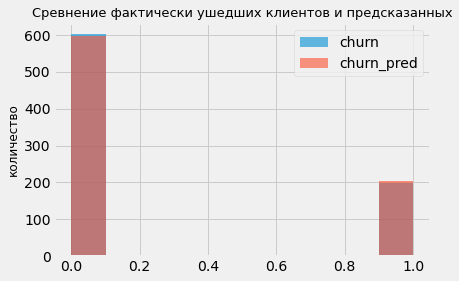

,mean,std
churn,0.2475,0.4318
churn_pred,0.2537,0.4354


In [22]:
df_reconscruct(final_model, df, 'churn')[['churn', 'churn_pred']].plot(kind='hist', alpha=0.6)
plt.title('Сревнение фактически ушедших клиентов и предсказанных', size=13)
plt.xlabel('', size=12)
plt.ylabel('количество', size=12)
plt.show()
df_reconscruct(final_model, df, 'churn')[['churn', 'churn_pred']].describe().T[['mean', 'std']]

Графики практически идеально накладываются друг на друга. Средние и стандартное отклонение говорят о том же. Модель работает.

## 5. Кластеризация клиентов
[к оглавлению](#step_0)
<a class="anchor" id="step_5"></a>

Для разбиения клиентов на группы - кластеры определим их количество с помощью дендрограммы.

Для начала избавимся от столбца с оттоком и стандартизируем данные способом, примененным в моделях классификации.

In [23]:
X = df.drop(['churn'], axis = 1) 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

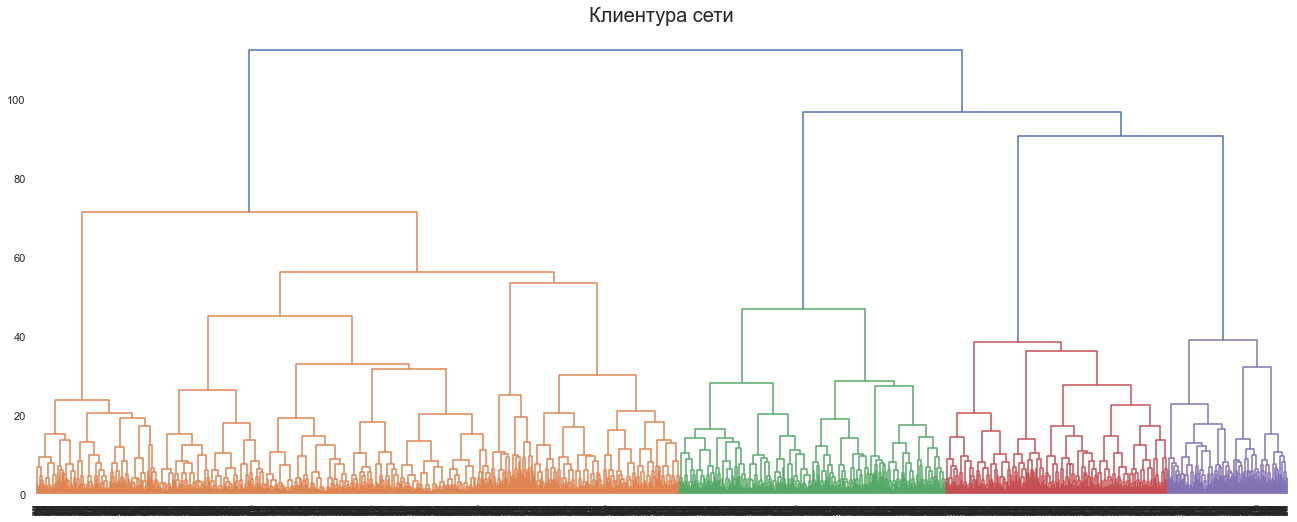

CPU times: user 39.3 s, sys: 5.24 s, total: 44.5 s
Wall time: 44.6 s


In [24]:
%%time
sns.set()
links = linkage(X_sc, method = 'ward')

plt.figure(figsize=(20, 8))
plt.title('Клиентура сети', size=20)
dendrogram(links, orientation='top')

plt.show()
plt.style.use('fivethirtyeight')

Делить клиентов на кластеры будем моделью K-means.  
Дендрограмма предлагает нам __4__ кластера. Прежде чем принять решение на сколько в итоге будем делить людей, прогоним модель с разным количеством кластеров через метрику __Silhouette__. Метрика показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой и принимает значения от __-1__ до __1__, чем ближе к __1__ тем лучше.

In [25]:
for i in range(2,8):
    km = KMeans(n_clusters = i, random_state=0)
    labels = km.fit_predict(X_sc)
    s_score = silhouette_score(X_sc, labels)
    print(f'Для {i} кластеров, silhouette = {s_score:.3f}')

Для 2 кластеров, silhouette = 0.165
Для 3 кластеров, silhouette = 0.210
Для 4 кластеров, silhouette = 0.182
Для 5 кластеров, silhouette = 0.154
Для 6 кластеров, silhouette = 0.160
Для 7 кластеров, silhouette = 0.156


Метрика показала наилучший результат при __трех__ кластерах. На них делить и будем.

Напишем функции для деления на кластеры и вывода отчета с характеристиками полученных кластеров

In [26]:
def clust_cuter(model, df, drop, n_clusters):
    '''
    ФУНКЦИЯ ДЛЯ ДЕЛЕНИЯ НА КЛАСТЕРЫ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца который нужно убрать и кол-во кластеров
    Внутри происходит следующее:
    1) Удаляем из датафрейма ненужный столбец
    2) Стандартизируем оставшиеся данные
    3) В зависимости от модели кластеризации получаем вектор с кластерами
    4) Добавляем к датафрейму вектор с кластерами
    5) Перенименовываем имена кластеров как clust_n
    6) Возвращаем датафрейм с кластерами
    '''
    X = df.drop([drop], axis = 1) 
    sc = StandardScaler()
    X_sc = sc.fit_transform(X)
    if model == 'KM':
        km = KMeans(n_clusters = n_clusters, random_state=0)
        labels = km.fit_predict(X_sc)
    if model == 'AC':
        ag = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = 'ward')
        ag.fit_predict(X_sc) 
        labels = ag.labels_
    df_c = df.copy()
    df_c['cluster'] = labels
    df_c['cluster'] = df_c['cluster'].apply(lambda x: 'clust_'+str(x+1))
    return df_c

In [27]:
def clust_features(model, df, drop, n_clusters):
    '''
    ФУНКЦИЯ ДЛЯ ВЫВОДА ХАРАКТЕРИСТИК КЛАСТЕРОВ
    ---------------------------
    На вход подается название модели, датафрейм, название столбца который нужно убрать и кол-во кластеров
    Внутри происходит следующее:
    1) Получаем датафрейс с кластерами функцией clust_cuter
    2) Группируем средние значения признаков по кластерам
    3) Выводим сгруппированную таблицу в виде таблицы heatmap
    4) К восстановленной валидационной выборке добавляем названия кластеров
    5) Смотрим как модел предсказывает отток по кластерам и сравниваем с фактом
    6) Возвращаем отчет
    '''
    df_c = clust_cuter(model, df, drop, n_clusters)
    fig = plt.figure(figsize=(8,10))
    sns.heatmap(df_c.groupby('cluster').mean().sort_values(by='churn', ascending=False).T, 
                annot=True, vmin=1, vmax=1000, 
                cmap = sns.color_palette(['#D3D3D3']), 
                fmt='.3g', linecolor = 'white', 
                linewidths=0.3, cbar=False)
    plt.title(f'Характеристики кластеров по методу\n {model}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0, size=20)
    plt.yticks(rotation=0, size=17)
    plt.show()

    df_cp = pd.merge(df_reconscruct(final_model, df, 'churn'), 
                     df_c['cluster'],  how='inner', left_index=True, right_index=True)
    df_cp = df_cp.groupby('cluster').agg({'churn':['count','sum','mean'],'churn_pred':['sum', 'mean']})
    df_cp.columns = ['cnt', 'churn_fact', 'churn_fact_%', 'churn_pred', 'churn_pred_%']
    display(df_cp.sort_values(by='churn_fact_%', ascending=False))

Поделим клиентов на кластеры и выведем их характеристики. Поскольку признаки в основном бинарные, то значение в таблице __= 0.5__ будет говорить о равенстве двух противоположных значений признака, если среднее значение ближе к __1__ значит больше __"ДА"__, если ближе к __0__ значит __"НЕТ"__. Среднее значение числовых признаков типа возраста или потраченных денег это собственно среднее значение. Чуть ниже выведем таблицу сравнения предсказанного оттока и фактического, но уже в разбивке по кластерам.

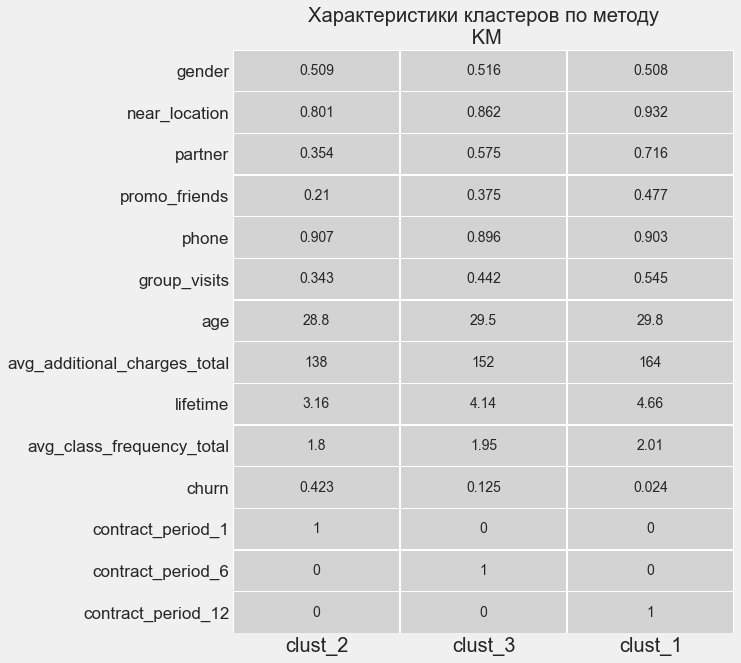

,cnt,churn_fact,churn_fact_%,churn_pred,churn_pred_%
cluster,,,,,
clust_2,450,182,0.4044,190,0.4222
clust_3,160,14,0.0875,13,0.0813
clust_1,190,2,0.0105,0,0.0000


In [28]:
clust_features('KM', df, 'churn', 3)

__Кластер №2__ _(в нашем случае номер не несет никакой смысловой нагрузки, это просто символ)_, показывает самый высокий уровень оттока -__42%__. Самый стойкий - __Кластер №1__ -__2%__. Примечательно что модель раздели кластеры четко по типам договоров. Фактический и предсказанный отток в разбивке по кластерам так же показывает ожидаемые значения. Более детальное описание характеристик продолжим после построения графиков признаков в разбивке по кластерам.

Прежде чем описывать результаты сравним деление на кластеры другой моделью - __Агломеративной иерархической кластеризацией__

In [29]:
for i in range(2,8):
    ag = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward') 
    ag.fit_predict(X_sc) 
    labels_ag = ag.labels_
    s_score = silhouette_score(X_sc, labels_ag)
    print(f'Для {i} кластеров, silhouette = {s_score:.3f}')

Для 2 кластеров, silhouette = 0.139
Для 3 кластеров, silhouette = 0.173
Для 4 кластеров, silhouette = 0.204
Для 5 кластеров, silhouette = 0.178
Для 6 кластеров, silhouette = 0.160
Для 7 кластеров, silhouette = 0.159


Модель показывает неплохие, но чуть худшие метрики и предлагает делить на __4__ кластера. Для сравнения с __K-means__ поделим все таки на __3__ кластера

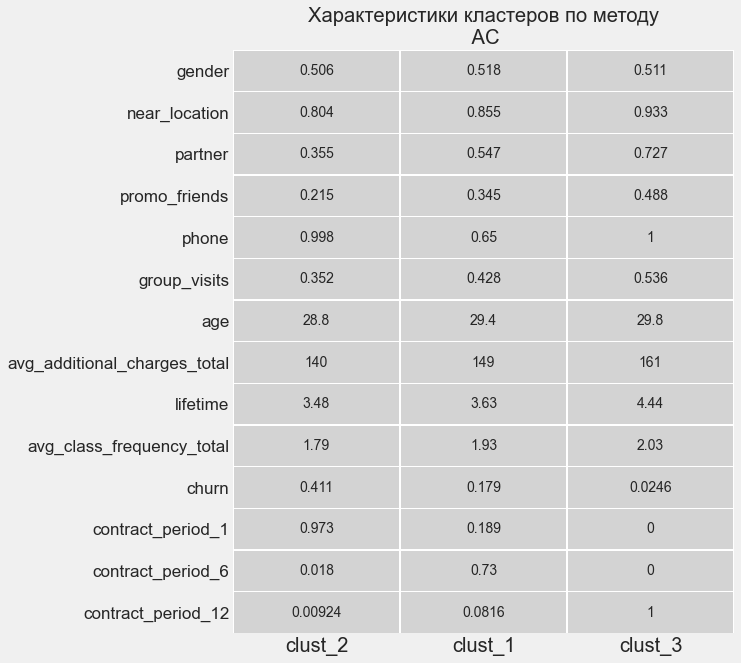

,cnt,churn_fact,churn_fact_%,churn_pred,churn_pred_%
cluster,,,,,
clust_2,414,164,0.3961,167,0.4034
clust_1,226,33,0.1460,36,0.1593
clust_3,160,1,0.0063,0,0.0000


In [30]:
clust_features('AC', df, 'churn', 3)

Модель чуть иначе разделила клиентов, но порядок цифр сохранился. В самом подверженном оттоку кластере уйдет более __40%__ клиентов, в самом лояльном около __2%__, в нейтральном __18%__. Учитывая более хорошие метрики __"Силуэта"__ у модели __K-Means__ на __трех__ кластерах остановим выбор на этой схеме

Сформируем кластеризованный датафрейм с помощью модели и подведем итоги

In [31]:
df_c = clust_cuter('KM', df, 'churn', 3)
df_c.head(3)

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,contract_period_1,contract_period_6,contract_period_12,cluster
0,1,1,1,1,0,1,29,14.2275,3,0.0204,0,0,1,0,clust_3
1,0,1,0,0,1,1,31,113.2029,7,1.9229,0,0,0,1,clust_1
2,0,1,1,0,1,0,28,129.4485,2,1.8591,0,1,0,0,clust_2


Построим графики распределения признаков для полученных кластеров

In [32]:
df_c = df_c.astype({'age': 'float64',
                    'lifetime': 'float64',})
column_ = df_c.drop(['cluster'], axis=1).dtypes.to_dict()

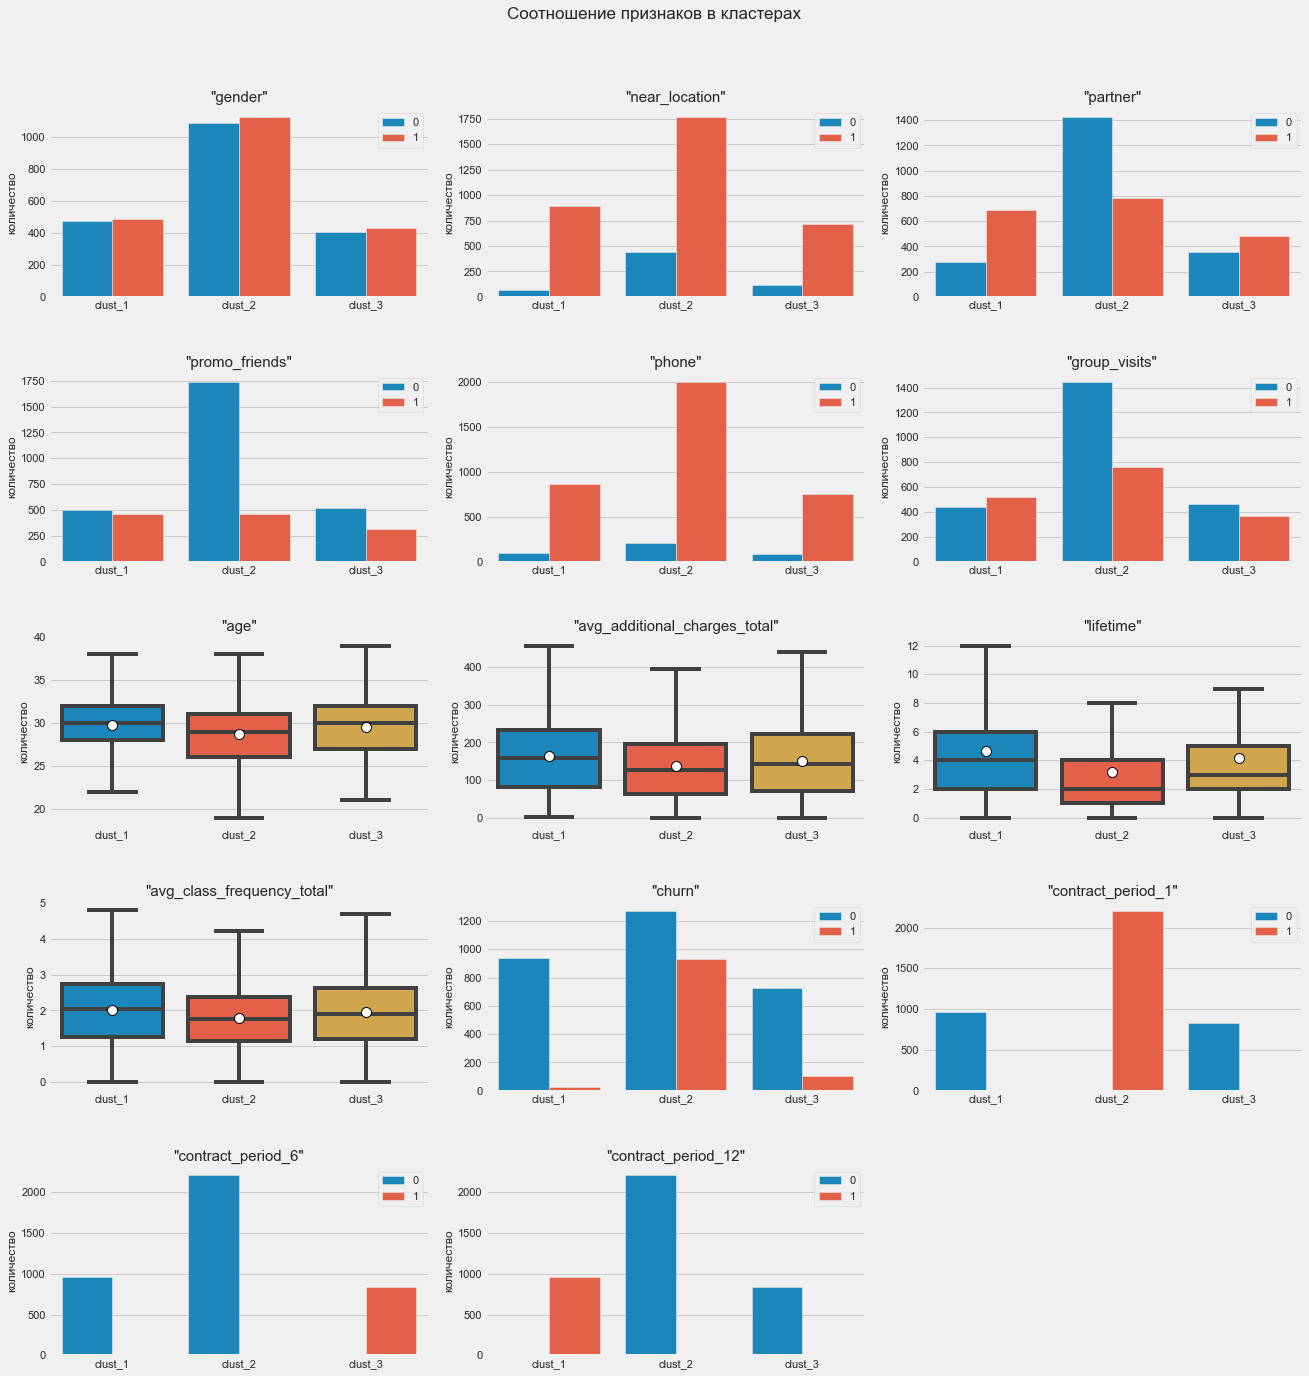

In [33]:
fig = plt.figure(figsize=(20,35))
i = 1
for key in column_:
    fig.add_subplot(8, 3, i)
    if column_[key] == 'int64' or column_[key] == 'uint8':
        data = df_c.groupby([key])['cluster'].value_counts().to_frame()
        data.columns = ['amount']
        sns.barplot(data = data.sort_values(by='cluster').reset_index(),
                    x='cluster', y = 'amount', hue=key,)
        plt.title(f'"{key}"', size=15)
        plt.legend(loc=1)
        plt.xlabel('', size=58)
        plt.ylabel('количество', size=12)
    elif column_[key] == 'float64':
        sns.boxplot(data= df_c.sort_values(by='cluster'), 
                    x='cluster', y=key, showfliers=False, showmeans=True, 
                    meanprops={'marker':'o', 
                               'markerfacecolor':'white',
                               'markeredgecolor':'black',
                               'markersize':'10'})
        plt.title(f'"{key}"', size=15)
        plt.xlabel('', size=12)
        plt.ylabel('количество', size=12)
    i += 1
plt.suptitle('Соотношение признаков в кластерах', size=17, y=0.92)
plt.subplots_adjust(wspace=0.15, hspace=0.4)
plt.show()

## 6. Выводы и рекомендации
[к оглавлению](#step_0)
<a class="anchor" id="step_6"></a>

Подводя итоги сформулируем характеристики кластеров пользователей:

| Признак  | "Склонные к оттоку"  | "Нейтральные"  | "Лояльные"  |
|:---|:---:|:---:|:---:|
|Время с момента первого обращения<br>__самый значимый признак__  |__3__ мес|__4__ мес|__4.5__ мес|
|Возраст - <br>__второй по значимости признак__ | __28.8__ <br>самые молодые  | __29.4__ | __29.9__<br>взрослые<br>основательные и надежные|
|Средняя частота посещений в неделю<br>__третий по значимости признак__|__1.8__|__1.9__|__2.3__|
|Наличие контракта<br>__среднезначимый признак__|__месячный__|__полугодовой__|__годовой__|
|Суммарная выручка от других услуг<br>__среднезначимый признак__ | __140__ денег| __150__ денег <br>перевалив за этот порог у<br>клиента больше шансов остаться|__160__ денег|
|Посещение групповых занятий<br>__среднезначимый признак__ | __65%__ игнорируют посещение |почти __половина__ посещает    | более __половины__ посещают |
|Пришли в рамках акции «приведи друга»<br>__среднезначимый признак__ |__1/5__ клиентов привели друзья|более __трети__ клиентов привели друзья   |почти __половину__ клиентов привели друзья|
|Наличие контактного телефона<br>__среднезначимый признак__ |примерно __90%__ оставили контакты|примерно __90%__ оставили контакты    |примерно __90%__ оставили контакты|
|Проживание или работа неподалеку <br>__не самый значимый признак__|__80%__ - местные | __85%__ - местные| __93%__ - местные  |   
|Сотрудник компании-партнёра <br> __не значимый признак__ |лишь __35%__ - сотрудники партнеров| более __50%__ - сотрудники партнеров   | почти __75%__ - сотрудники партнеров   |
|Пол <br>__самый не значимый признак__|Деление по полам примерно __1:1__|Деление по полам примерно __1:1__|Деление по полам примерно __1:1__ |

Самые подверженные к оттоку клиенты это взаимодействующие до 3 месяцев, возрастом до 28 лет, посещающие занятия не чаще 1.8 раз в неделю, имеющие месячный абонемент, потратившие до 140 денег, пришедшие сами по себе, живущие или работающие не в самой близости и не являющиеся сотрудником компании партнера.  При наличии все этих признаков шанс что клиент перейдет в отток более 40%


__Рекомендации сотрудникам CRM__:   

В основном стараться переводить клиентов с признаками оттока в более лояльные кластеры:  
>- Стимулировать занятия в группах.  
>- Предлагать уже занимающимся клиентам приводить друзей за различные бонусы.  
>- Ввести промежуточный тип договора - __3 месяца__.  
>- Интенсивней предлагать услугу занятия спортом сотрудникам компаний-партнеров.